<a href="https://colab.research.google.com/github/simnarassak/MarketBasketAnalysis/blob/master/forecastingFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import io
import pickle
from tqdm.notebook import tqdm as log_progress
import seaborn as sns
sns.set_theme()
sns.set_style('darkgrid')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


#--------scale---------------------------------------
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file1 = files.upload()#avocado yield file
file2 = files.upload()#Weather file (max and min temp)
file3=files.upload()#NDVI
file4=files.upload()#EVI
file5=files.upload()#NDMI
file6=files.upload()#SAVI

Saving yield_data_9170.csv to yield_data_9170.csv


Saving climate_9170.csv to climate_9170.csv


Saving NDVI.csv to NDVI.csv


Saving EVI.csv to EVI.csv


Saving NDMI.csv to NDMI.csv


Saving SAVI.csv to SAVI.csv


In [ ]:
file7 = files.upload()#rain

Saving rain.xlsx to rain.xlsx


In [ ]:
NDVI=pd.read_csv(io.BytesIO(file3['NDVI.csv']))
EVI=pd.read_csv(io.BytesIO(file4['EVI.csv']))
NDMI=pd.read_csv(io.BytesIO(file5['NDMI.csv']))
SAVI=pd.read_csv(io.BytesIO(file6['SAVI.csv']))

In [ ]:
rain=pd.read_excel(io.BytesIO(file7['rain.xlsx']))

In [ ]:
df1=pd.read_csv(io.BytesIO(file1['yield_data_9170.csv']))
df2=pd.read_csv(io.BytesIO(file2['climate_9170.csv']))

In [ ]:
#Merge the vegetation indices files
VI1=pd.merge(NDVI, EVI, on='Date',how="left")
VI2=pd.merge(VI1, NDMI, on='Date',how="left")
VI3=pd.merge(VI2, SAVI, on='Date',how="left")

In [ ]:
# Function to set index - Date 
def set_date_index(input_df, col_name='Date'):
   
    # Copy df to prevent changing original
    modified_df = input_df.copy()

    # Infer datetime from col
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])

    # Sort and set index
    modified_df.sort_values(col_name, inplace=True)
    modified_df.set_index(col_name, inplace=True)

    return modified_df

In [ ]:
d1=set_date_index(df1)
d2=set_date_index(df2)
d3=set_date_index(VI3)

In [ ]:
d4=set_date_index(rain)

In [ ]:
d4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1933 entries, 2013-10-01 to 2019-02-28
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rain_Amount  1933 non-null   float64
 1   Deficit      1933 non-null   float64
dtypes: float64(2)
memory usage: 45.3 KB


In [ ]:
d3.head(2)

,NDVI,EVI,NDMI,SAVI
Date,,,,
2013-05-20,0.783,0.847,0.599,0.709
2013-06-05,0.772,0.867,0.601,0.695


In [ ]:
#fill the small gaps in the Vegetation indices data

"""
There are 3 methods to fill small gaps in data using resample method. 
forwad filling, backword filling and interpolate

"""
df1_yield=d1.resample('1D').mean().fillna(0)
df2_weth=d2.resample('1D').mean().interpolate()
df3_VI=d3.resample('1D').mean().interpolate() # interpolate the missing gap in data

In [ ]:
df1_yield.head(2)

,Yield,Area
Date,,
2013-10-09,393.14,20.0
2013-10-10,0.00,0.0


In [ ]:
dv=pd.merge(df1_yield, df2_weth, on='Date',how="left")# merge yield and weather data
data_t=pd.merge(dv,d4,on='Date',how='left')#merge the data with vegetation indices

In [ ]:
data_ts=pd.merge(data_t,df3_VI,on='Date',how='left')

In [ ]:
data_ts.head(2)

,Yield,Area,Tmax,Tmin,Rain_Amount,Deficit,NDVI,EVI,NDMI,SAVI
Date,,,,,,,,,,
2013-10-09,393.14,20.0,16.9,8.3,0.0,31.9,0.757,0.867875,0.481938,0.700187
2013-10-10,0.00,0.0,17.9,8.5,0.8,34.1,0.756,0.862437,0.480719,0.698844


In [ ]:
#data_ts['n_Yield']=data_ts['Yield']/data_ts['Area'] # normalize the yield by dividing the orginal value with area

In [ ]:
data_ts.head(2)

,Yield,Area,Tmax,Tmin,Rain_Amount,Deficit,NDVI,EVI,NDMI,SAVI
Date,,,,,,,,,,
2013-10-09,393.14,20.0,16.9,8.3,0.0,31.9,0.757,0.867875,0.481938,0.700187
2013-10-10,0.00,0.0,17.9,8.5,0.8,34.1,0.756,0.862437,0.480719,0.698844


In [ ]:
from pylab import rcParams

In [ ]:
data_ts=data_ts.drop("Area", axis=1)

In [ ]:
#data_ts['n_Yield']=data_ts['n_Yield'].fillna(0)

In [ ]:
for i in data_ts.columns[0:9]:
    val=data_ts[i].mean()
    data_ts[i]=data_ts[i].transform(lambda x: x.interpolate(limit_direction='both')).fillna(val)

In [ ]:
data_ts.head(3)

,Yield,Tmax,Tmin,Rain_Amount,Deficit,NDVI,EVI,NDMI,SAVI
Date,,,,,,,,,
2013-10-09,393.14,16.9,8.3,0.0,31.9,0.757,0.867875,0.481938,0.700187
2013-10-10,0.00,17.9,8.5,0.8,34.1,0.756,0.862437,0.480719,0.698844
2013-10-11,381.65,20.2,13.9,0.0,37.0,0.755,0.857000,0.479500,0.697500


In [ ]:
df = data_ts.rename(columns={'Date': 'ds', 'Yield': 'y'})
data = df.sort_values(['Date'])#sort the value based on Date
data=data.reset_index()#reset the index
data = data.rename(columns={'Date': 'ds'})#change the date column name as 'ds'

In [ ]:
#scale the whole data
for i in data.columns[1:12]:
    data[i]=scaler.fit_transform(data[i].values.reshape(-1, 1))

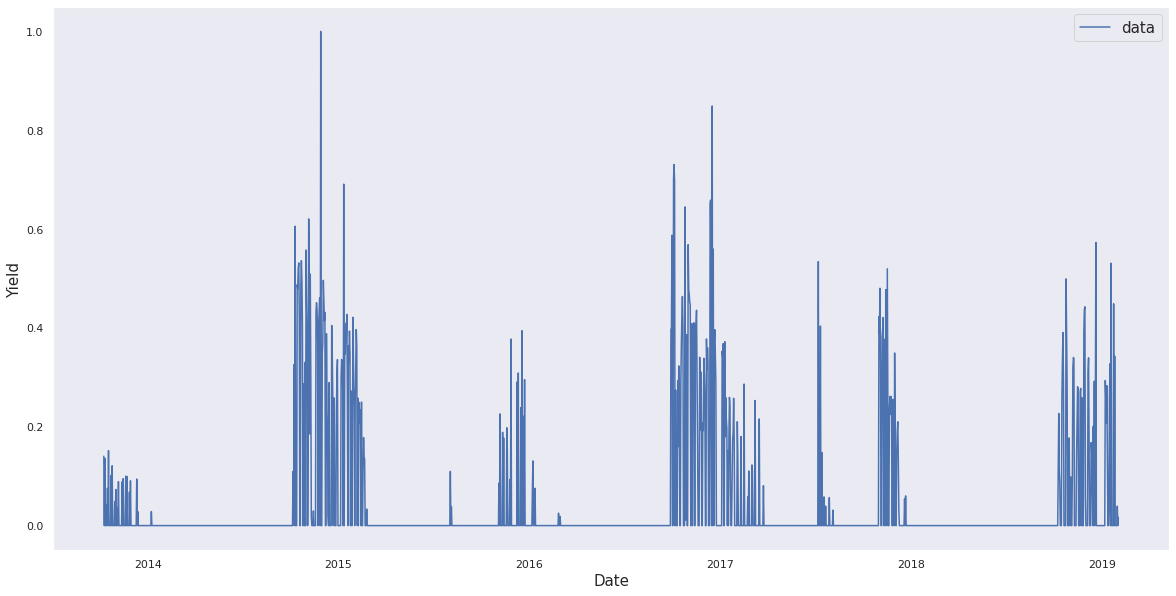

In [ ]:
rcParams['figure.figsize'] = 20, 10
true_values = np.array(data['y'])
plt.plot(data['ds'], true_values, label = 'data')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Yield', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

In [ ]:
#data=data.drop("Yield", axis=1)

In [ ]:
data.head(10)

,ds,y,Tmax,Tmin,Rain_Amount,Deficit,NDVI,EVI,NDMI,SAVI
0,2013-10-09,0.140266,0.297170,0.352113,0.000000,0.217155,0.950601,0.800764,0.367895,0.925301
1,2013-10-10,0.000000,0.344340,0.361502,0.006192,0.232131,0.949266,0.794613,0.365547,0.923400
2,2013-10-11,0.136167,0.452830,0.615023,0.000000,0.251872,0.947931,0.788462,0.363198,0.921499
3,2013-10-12,0.000000,0.627358,0.563380,0.052632,0.226004,0.946595,0.782311,0.360850,0.919599
4,2013-10-13,0.000000,0.363208,0.539906,0.017028,0.230769,0.945260,0.776160,0.358502,0.917698
5,2013-10-14,0.042457,0.457547,0.460094,0.000000,0.251191,0.943925,0.770008,0.356154,0.915797
6,2013-10-15,0.000000,0.514151,0.694836,0.007740,0.264125,0.942590,0.763857,0.353805,0.913897
7,2013-10-16,0.075392,0.471698,0.338028,0.032508,0.255276,0.941255,0.757706,0.351457,0.911996
8,2013-10-17,0.000000,0.396226,0.492958,0.000000,0.275698,0.939920,0.751555,0.349109,0.910095
9,2013-10-18,0.151619,0.490566,0.356808,0.000000,0.295439,0.938585,0.745404,0.346761,0.908195


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942 entries, 0 to 1941
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ds           1942 non-null   datetime64[ns]
 1   y            1942 non-null   float64       
 2   Tmax         1942 non-null   float64       
 3   Tmin         1942 non-null   float64       
 4   Rain_Amount  1942 non-null   float64       
 5   Deficit      1942 non-null   float64       
 6   NDVI         1942 non-null   float64       
 7   EVI          1942 non-null   float64       
 8   NDMI         1942 non-null   float64       
 9   SAVI         1942 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 151.8 KB


In [ ]:
#holidays
ss=pd.bdate_range(start="2013/10/09", end="2019/02/01", freq="C", weekmask="Sat Sun")
we = pd.DataFrame({'ds': pd.to_datetime(ss),'holiday': 'weekends'})
holidays=we

In [ ]:
!pip install Prophet

In [ ]:
!pip install prophet

In [ ]:
!pip install fbprophet

In [ ]:

!pip install pip --upgrade

In [ ]:
!apt-get install python3.9
!python3.9 setup.py

In [ ]:
import fbprophet as Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score, mean_absolute_percentage_error
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [ ]:
data.tail(10)

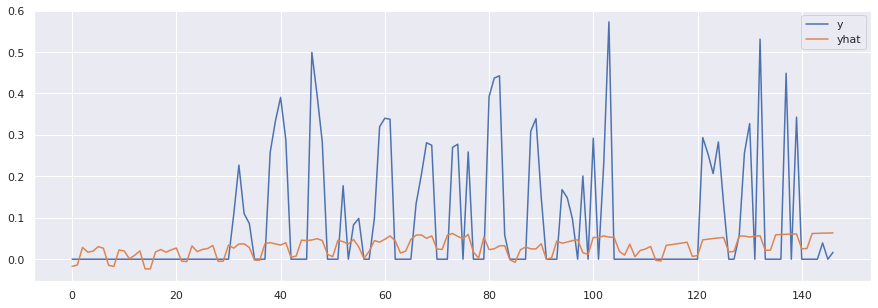

In [ ]:
#split the total data-
#250 days is used for train and remaining is used for test- forecast
train=data[:-147]
test=data[-147:]
test1=test[['ds','Tmax','Tmin','NDVI','EVI','NDMI','SAVI','Rain_Amount','Deficit']]
model1= Prophet.Prophet(interval_width=0.95,holidays=holidays,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)

model1.add_regressor('Tmax',standardize=False)
model1.add_regressor('Tmin',standardize=False)
model1.add_regressor('NDVI',standardize=False)
model1.add_regressor('EVI',standardize=False)
model1.add_regressor('NDMI',standardize=False)
model1.add_regressor('SAVI',standardize=False)
model1.add_regressor('Rain_Amount',standardize=False)
model1.add_regressor('Deficit',standardize=False)

model1.fit(train)
forecast1 = model1.predict(test1)
fb_forecast1=forecast1[['ds','yhat','yhat_lower', 'yhat_upper']]
prediction1=pd.merge(fb_forecast1,test,on='ds',how='left')
_ = prediction1[['y','yhat']].plot(figsize=(15, 5))

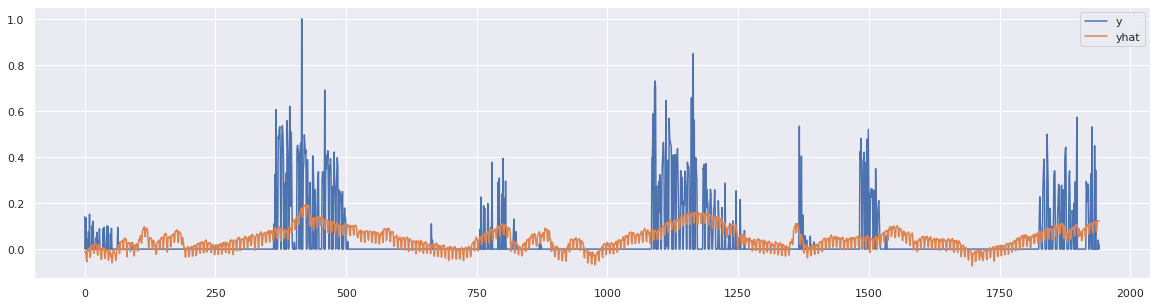

In [ ]:
model10= Prophet.Prophet(interval_width=0.95,holidays=holidays,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)

model10.add_regressor('Tmax',standardize=False)
model10.add_regressor('Tmin',standardize=False)
model10.add_regressor('NDVI',standardize=False)
model10.add_regressor('EVI',standardize=False)
model10.add_regressor('NDMI',standardize=False)
model10.add_regressor('SAVI',standardize=False)
model10.add_regressor('Rain_Amount',standardize=False)
model10.add_regressor('Deficit',standardize=False)

model10.fit(data)
forecast10 = model10.predict(data)
fb_forecast10=forecast10[['ds','yhat','yhat_lower', 'yhat_upper']]
prediction10=pd.merge(fb_forecast10,data,on='ds',how='left')
_ = prediction10[['y','yhat']].plot(figsize=(20, 5))

In [ ]:
plot_plotly(model1, forecast1)

In [ ]:
plot_components_plotly(model1, forecast1)

In [ ]:
model2= Prophet.Prophet(interval_width=0.95,holidays=holidays)


In [ ]:
model2.fit(data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future=model2.make_future_dataframe(periods = 8*7)
forecast2=model2.predict(future)


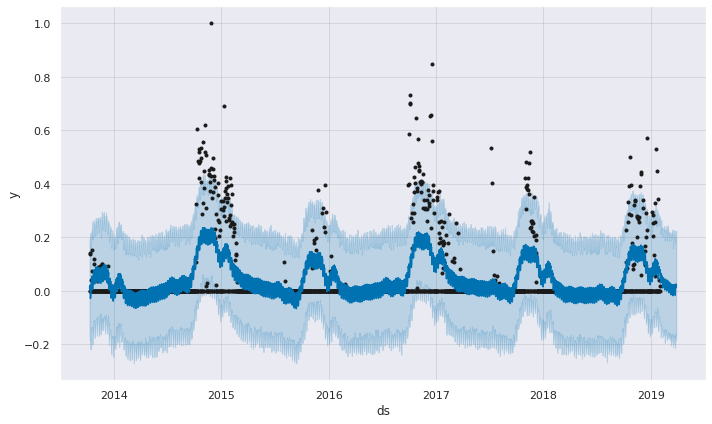

In [ ]:
fig1 = model2.plot(forecast2)

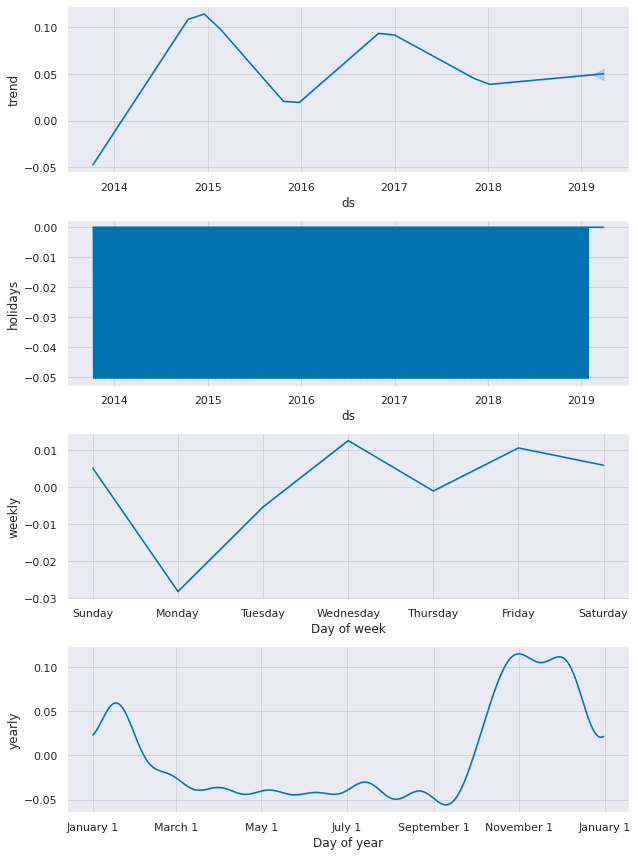

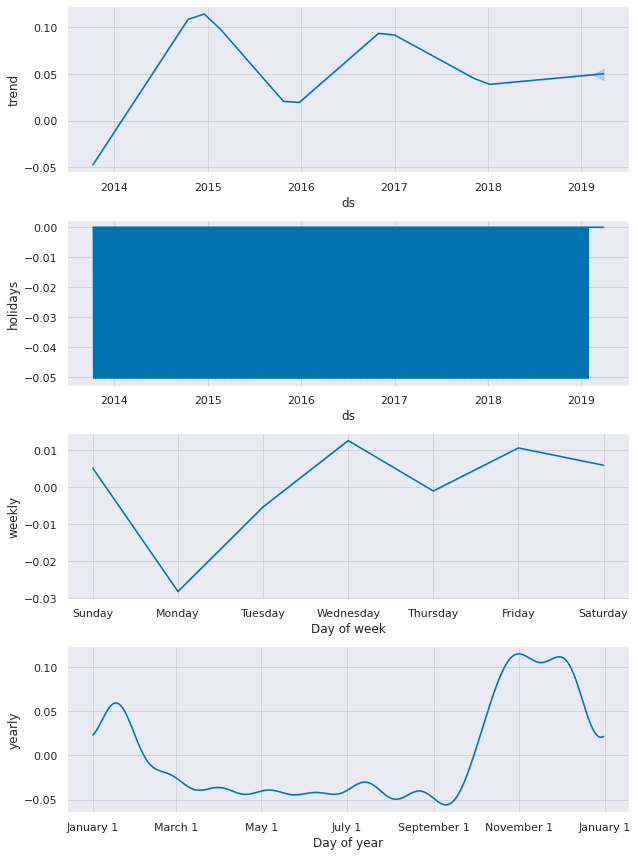

In [ ]:
model2.plot_components(forecast2)

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import plot_cross_validation_metric

In [ ]:
plot_plotly(model2, forecast2)

In [ ]:
plot1=model2.plot(forecast2)
#a=add_changepoints_to_plot(plot1.gca(),model2,forecast2)

In [ ]:
df_merge=pd.merge(test,forecast2[['ds','yhat_lower','yhat_upper','yhat']],on='ds',how='left')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2018-09-08,-0.277724,0.133550,-0.080025,0.0
1,2018-09-09,-0.292942,0.130459,-0.080093,0.0
2,2018-09-10,-0.290254,0.156812,-0.061420,0.0
3,2018-09-11,-0.256923,0.165751,-0.040331,0.0
4,2018-09-12,-0.234875,0.176835,-0.025701,0.0


In [ ]:
data3=data

In [ ]:
data3['y_cumsum']=data3['y'].cumsum()

In [ ]:
#data3=data3.drop("y", axis=1)
#data3 = data3.rename(columns={ 'y_cumsum': 'y'})

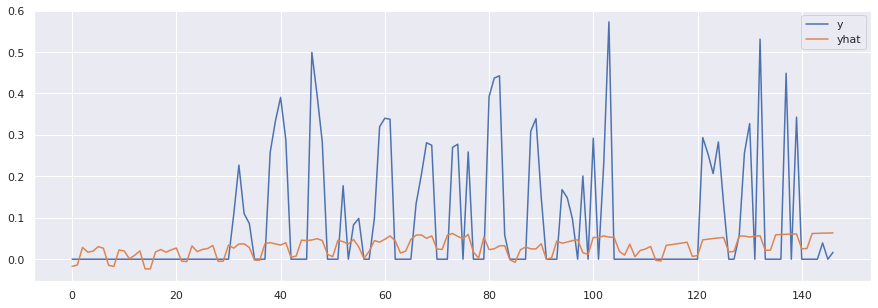

In [ ]:
train3=data3[:-147]
test3=data3[-147:]
test4=test3[['ds','Tmax','Tmin','NDVI','EVI','NDMI','SAVI','Rain_Amount','Deficit','y_cumsum']]
model3= Prophet.Prophet(interval_width=0.95,holidays=holidays,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)

model3.add_regressor('Tmax',standardize=False)
model3.add_regressor('Tmin',standardize=False)
model3.add_regressor('NDVI',standardize=False)
model3.add_regressor('EVI',standardize=False)
model3.add_regressor('NDMI',standardize=False)
model3.add_regressor('SAVI',standardize=False)
model3.add_regressor('Rain_Amount',standardize=False)
model3.add_regressor('Deficit',standardize=False)
model3.add_regressor('y_cumsum',standardize=False)
model3.fit(train3)
forecast3 = model3.predict(test4)
fb_forecast3=forecast3[['ds','yhat','yhat_lower', 'yhat_upper']]
prediction3=pd.merge(fb_forecast1,test3,on='ds',how='left')
_ = prediction3[['y','yhat']].plot(figsize=(15, 5))

In [ ]:
data3.head(2)

,ds,Tmax,Tmin,NDVI,EVI,NDMI,SAVI,Rain_Amount,Deficit,y
0,2013-10-09,0.29717,0.352113,0.950601,0.800764,0.367895,0.925301,0.000000,0.217155,0.140266
1,2013-10-10,0.34434,0.361502,0.949266,0.794613,0.365547,0.923400,0.006192,0.232131,0.140266


In [ ]:
model3= Prophet.Prophet(interval_width=0.95,holidays=holidays)

In [ ]:
model3.fit(train2)
future2=model3.make_future_dataframe(periods = 8*7)
forecast3=model3.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
plot_plotly(model3, forecast3)

In [ ]:
data.head(2)

,ds,Tmax,Tmin,NDVI,EVI,NDMI,SAVI,Rain_Amount,Deficit,y,y_cumsum
0,2013-10-09,0.29717,0.352113,0.950601,0.800764,0.367895,0.925301,0.000000,0.217155,0.140266,0.140266
1,2013-10-10,0.34434,0.361502,0.949266,0.794613,0.365547,0.923400,0.006192,0.232131,0.000000,0.140266


In [ ]:
data2=data.drop("y", axis=1)
data3 = data2.rename(columns={ 'y_cumsum': 'y'})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


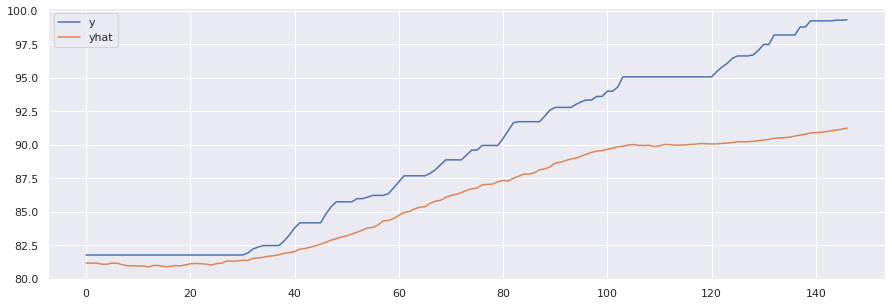

In [ ]:
#split the total data-
#250 days is used for train and remaining is used for test- forecast
train3=data3[:-147]
test3=data3[-147:]
test4=test[['ds','Tmax','Tmin','NDVI','EVI','NDMI','SAVI','Rain_Amount','Deficit']]
model4= Prophet.Prophet(interval_width=0.95,holidays=holidays)

model4.add_regressor('Tmax',standardize=False)
model4.add_regressor('Tmin',standardize=False)
model4.add_regressor('NDVI',standardize=False)
model4.add_regressor('EVI',standardize=False)
model4.add_regressor('NDMI',standardize=False)
model4.add_regressor('SAVI',standardize=False)
model4.add_regressor('Rain_Amount',standardize=False)
model4.add_regressor('Deficit',standardize=False)

model4.fit(train3)
forecast4 = model4.predict(test4)
fb_forecast4=forecast4[['ds','yhat','yhat_lower', 'yhat_upper']]
prediction4=pd.merge(fb_forecast4,test3,on='ds',how='left')
_ = prediction4[['y','yhat']].plot(figsize=(15, 5))

In [ ]:
plot_plotly(model4, forecast4)

In [ ]:
plot_components_plotly(model4, forecast4)

In [ ]:
data.head(20)

NeuralProphet

In [ ]:
!pip install neuralprophet

In [ ]:
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [ ]:
data.head(3)

,ds,y,Tmax,Tmin,Rain_Amount,Deficit,NDVI,EVI,NDMI,SAVI
0,2013-10-09,0.140266,0.29717,0.352113,0.000000,0.217155,0.950601,0.800764,0.367895,0.925301
1,2013-10-10,0.000000,0.34434,0.361502,0.006192,0.232131,0.949266,0.794613,0.365547,0.923400
2,2013-10-11,0.136167,0.45283,0.615023,0.000000,0.251872,0.947931,0.788462,0.363198,0.921499


In [ ]:
data['ds']=pd.to_datetime(data['ds'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942 entries, 0 to 1941
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ds           1942 non-null   datetime64[ns]
 1   y            1942 non-null   float64       
 2   Tmax         1942 non-null   float64       
 3   Tmin         1942 non-null   float64       
 4   Rain_Amount  1942 non-null   float64       
 5   Deficit      1942 non-null   float64       
 6   NDVI         1942 non-null   float64       
 7   EVI          1942 non-null   float64       
 8   NDMI         1942 non-null   float64       
 9   SAVI         1942 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 151.8 KB


In [ ]:
data.set_index('ds',inplace=True)

In [ ]:
g=data.groupby(pd.Grouper(freq='M'))
data['cumsum_yield']=g['y'].cumsum()

In [ ]:
data.head(2)

,y,Tmax,Tmin,Rain_Amount,Deficit,NDVI,EVI,NDMI,SAVI,cumsum_yield
ds,,,,,,,,,,
2013-10-09,0.140266,0.29717,0.352113,0.000000,0.217155,0.950601,0.800764,0.367895,0.925301,0.140266
2013-10-10,0.000000,0.34434,0.361502,0.006192,0.232131,0.949266,0.794613,0.365547,0.923400,0.140266


In [ ]:
data=data.reset_index()

In [ ]:
#data=data.drop("y_cumsum", axis=1)

In [ ]:
indep=list(data)[2:10]

In [ ]:
indep

['Tmax', 'Tmin', 'Rain_Amount', 'Deficit', 'NDVI', 'EVI', 'NDMI', 'SAVI']

In [ ]:
dep=pd.DataFrame()

In [ ]:
dep['ds']=data['ds']
dep['y']=data['cumsum_yield']

In [ ]:
dep.head(2)

,ds,y
0,2013-10-09,0.140266
1,2013-10-10,0.140266


In [ ]:
dummy=data

In [ ]:
dummy.head(2)

,ds,y,Tmax,Tmin,Rain_Amount,Deficit,NDVI,EVI,NDMI,SAVI,cumsum_yield
0,2013-10-09,0.140266,0.29717,0.352113,0.000000,0.217155,0.950601,0.800764,0.367895,0.925301,0.140266
1,2013-10-10,0.000000,0.34434,0.361502,0.006192,0.232131,0.949266,0.794613,0.365547,0.923400,0.140266


In [ ]:
data.to_csv("data_9170.csv")
!cp data_9170.csv "drive/My Drive/"

In [ ]:
dummy=dummy.drop("n_Yield", axis=1)

In [ ]:
dummy = dummy.rename(columns={ 'cumsum_yield': 'y'})

In [ ]:
m = NeuralProphet(
    n_forecasts=3,
    n_lags=3,
    learning_rate= 0.1,
)
m = m.add_lagged_regressor(names=indep) #, only_last_value=True)
m.highlight_nth_step_ahead_of_each_forecast(3)
metrics = m.fit(dummy, freq="D")

In [ ]:
m2=NeuralProphet(
    n_forecasts=3,
    n_lags=3,
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,)
m2 = m2.add_lagged_regressor(names=indep)
m2.highlight_nth_step_ahead_of_each_forecast(3)
metrics2 = m2.fit(data, freq="D")

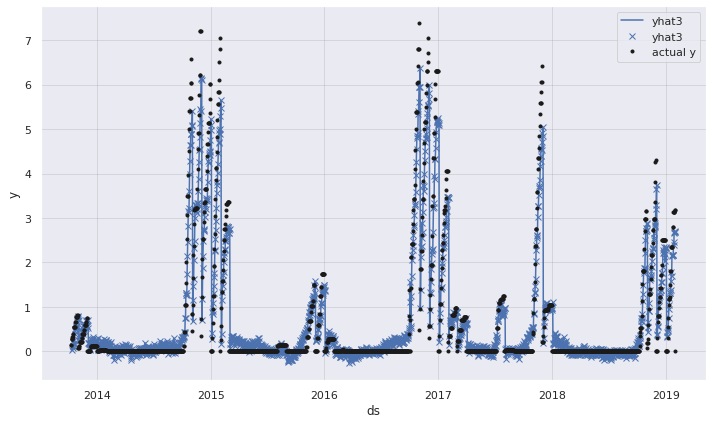

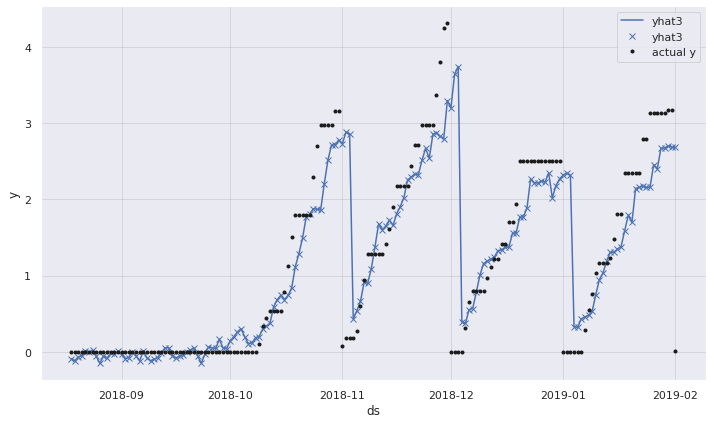

In [ ]:
new_forecast = m.predict(dummy)
# fig = m.plot(forecast)
fig1 = m.plot(new_forecast[-365*24:])
fig2 = m.plot(new_forecast[-7*24:])
# comp = m.plot_components(forecast[-7*24:])
#param = m.plot_parameters()

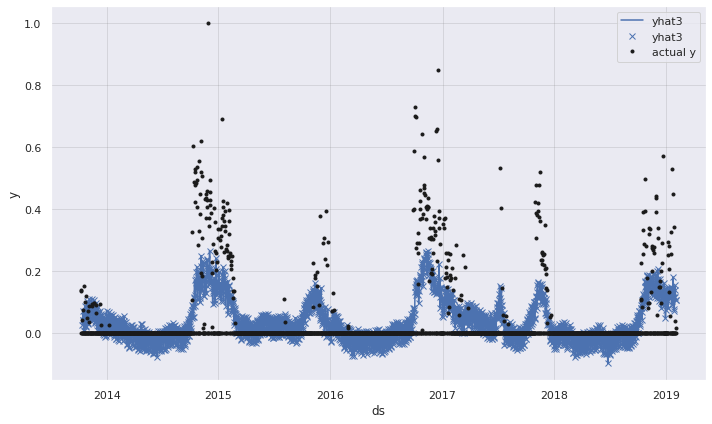

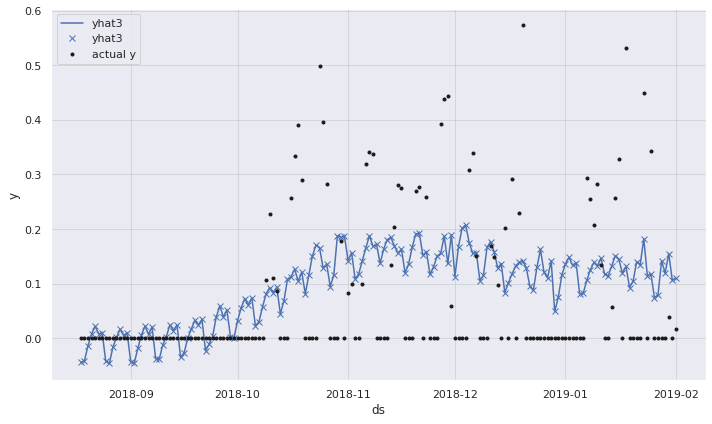

In [ ]:
new_forecast2 = m2.predict(data)
# fig = m.plot(forecast)
fig1 = m2.plot(new_forecast2[-365*24:])
fig2 = m2.plot(new_forecast2[-7*24:])
# comp = m.plot_components(forecast[-7*24:])
#param2 = m2.plot_parameters()

changing trend

In [ ]:
future = m.make_future_dataframe(dummy, periods=365, n_historic_predictions=True)

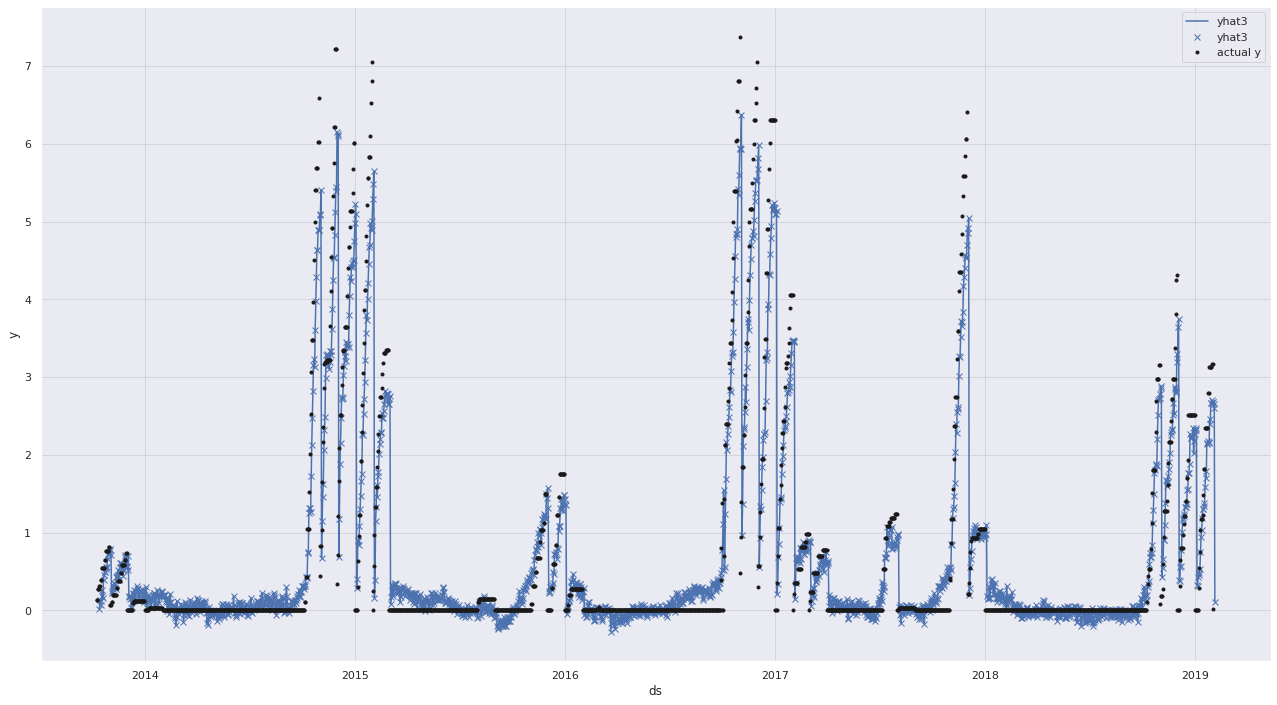

In [ ]:
new_forecast3 = m.predict(future)
fig1 = m.plot(new_forecast3)
fig1.set_size_inches(18.5, 10.5)

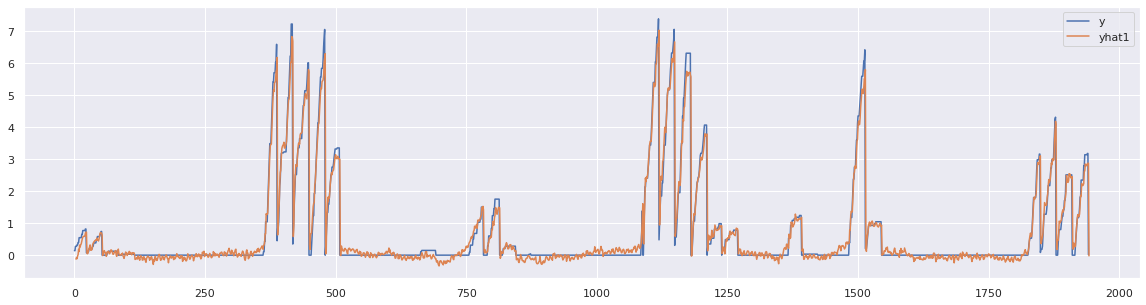

In [ ]:
_ = new_forecast3[['y','yhat1']].plot(figsize=(20, 5))

In [ ]:
_=new_forecast3.y.rolling(5).mean().plot(figsize=(20, 5))

In [ ]:
_=new_forecast3.yhat1.rolling(5).mean().plot(figsize=(20, 5))

In [ ]:
p2=new_forecast3

In [ ]:
p2.head(2)

In [ ]:
p2['r_mean']=p2['yhat1'].rolling(3).mean()

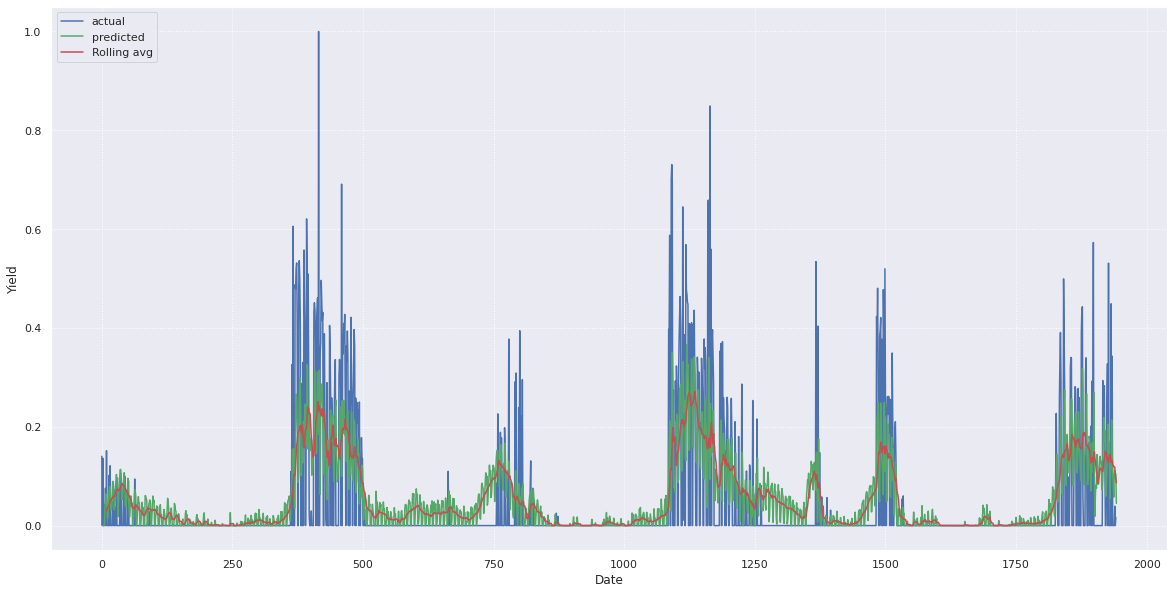

In [ ]:
plt.plot(p2.y,'b-',label='actual')
plt.plot(p2.yhat1.clip(lower=0),'g-',label='predicted')
plt.plot(p2['yhat1'].clip(lower=0).rolling(7).mean(),'r-',label='Rolling avg')
plt.ylabel('Yield')
plt.xlabel('Date')
plt.grid(linestyle=':')
plt.legend(loc='upper left')
plt.show()

In [ ]:
p3=new_forecast3

In [ ]:
p3['r_mean']=p3['yhat1'].rolling(3).mean()

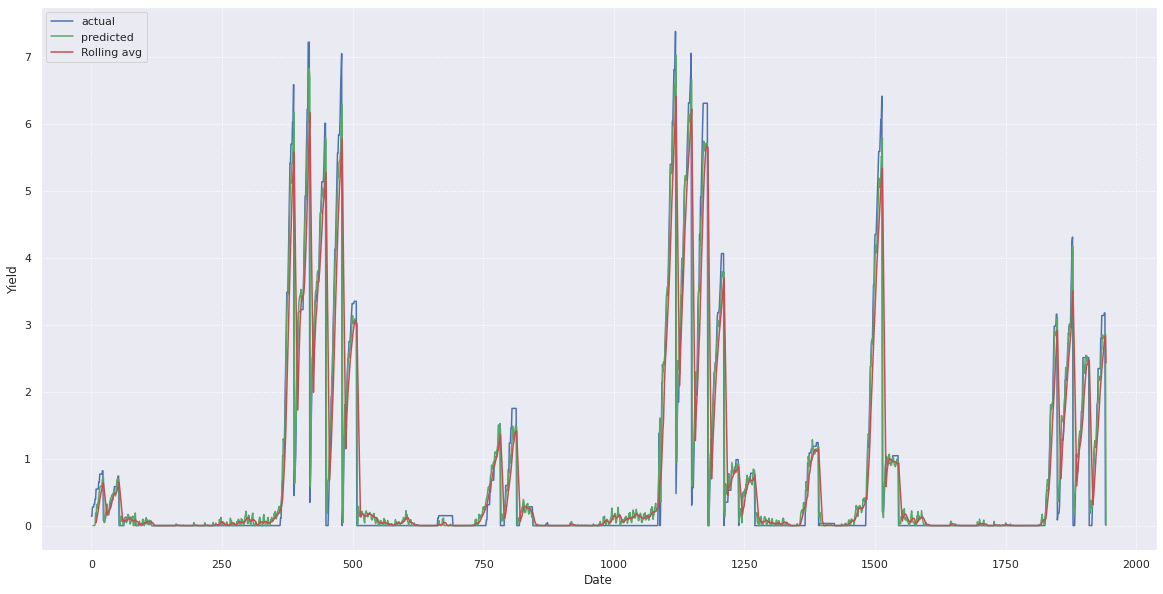

In [ ]:
plt.plot(p3.y,'b-',label='actual')
plt.plot(p3.yhat1.clip(lower=0),'g-',label='predicted')
plt.plot(p3['yhat1'].clip(lower=0).rolling(7).mean(),'r-',label='Rolling avg')
plt.ylabel('Yield')
plt.xlabel('Date')
plt.grid(linestyle=':')
plt.legend(loc='upper left')
plt.show()

In [ ]:
index = pd.date_range("2013/10/09", "2019/03/01")
s = index.to_series()

In [ ]:
s.head(2)

In [ ]:
s[(s.dt.month * 100 + s.dt.day).between(310, 500)]

In [ ]:
dummy2.head(3)

In [ ]:
dummy2=dummy2.drop("index", axis=1)

In [ ]:

dummy3=pd.merge(dummy2,s.rename('ds'),on='ds',how='left')

In [ ]:
dummy3['cc']=dummy3[(dummy3.ds.dt.month * 100 + dummy3.ds.dt.day).between(1009, 1240)]['y'].cumsum()

In [ ]:
dummy3[(dummy3.ds.dt.month * 100 + dummy3.ds.dt.day).between(1009, 1240)]

In [ ]:
dummy3=dummy3.fillna(0)

In [ ]:
dummy3.head(2)

,ds,Tmax,Tmin,NDVI,EVI,NDMI,SAVI,Rain_Amount,Deficit,y
0,2013-10-09,0.29717,0.352113,0.950601,0.800764,0.367895,0.925301,0.000000,0.217155,0.140266
1,2013-10-10,0.34434,0.361502,0.949266,0.794613,0.365547,0.923400,0.006192,0.232131,0.140266


In [ ]:
dummy3=dummy3.drop("cumsum_yield", axis=1)

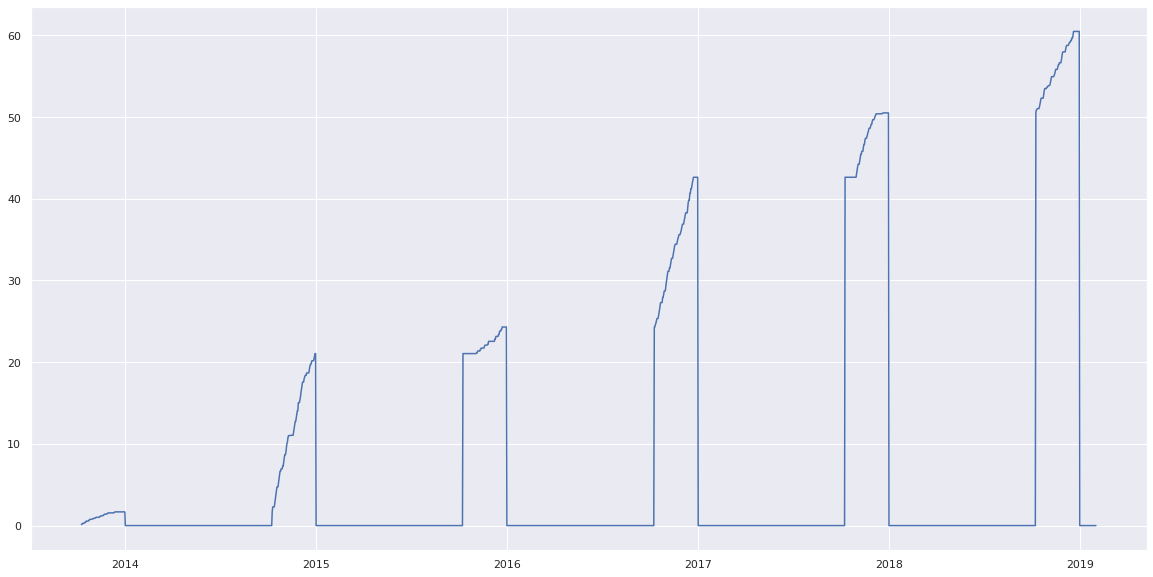

In [ ]:
plt.plot(dummy3['ds'],dummy3['y'])

In [ ]:
dummy3=dummy3.rename(columns={ 'cc': 'y'})

In [ ]:
dep['ds']=dummy3['ds']
dep['y']=dummy3['y']

In [ ]:
model_3=NeuralProphet(
    n_forecasts=3,
    n_lags=3,
    learning_rate=0.01,
    n_changepoints=30,
    changepoints_range=0.90,
    trend_reg=1,
)
model_3 = model_3.add_lagged_regressor(names=indep)
metrics3 = model_3.fit(dummy3, freq="D")

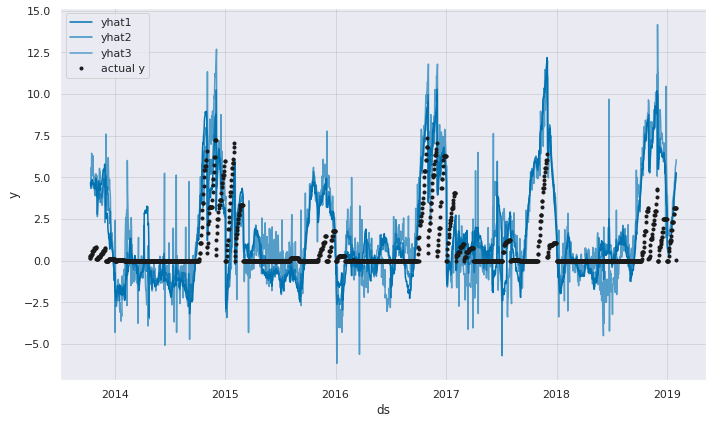

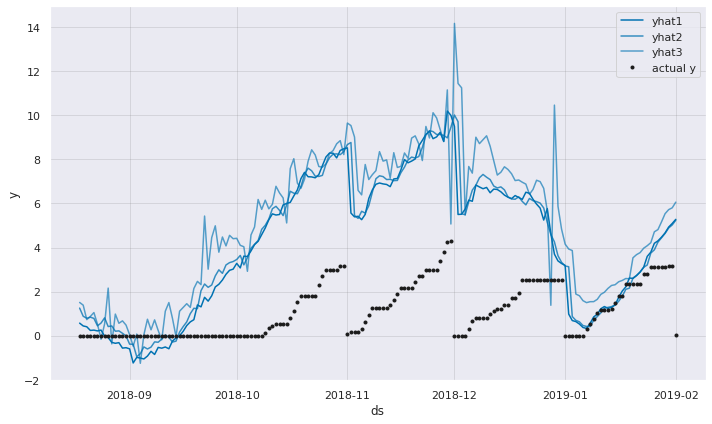

In [ ]:
model_3_forecast = model_3.predict(dummy)
# fig = m.plot(forecast)
fig1 = model_3.plot(model_3_forecast[-365*24:])
fig2 = model_3.plot(model_3_forecast[-7*24:])

In [ ]:
n_future = model_3.make_future_dataframe(dummy3, periods=365, n_historic_predictions=True)

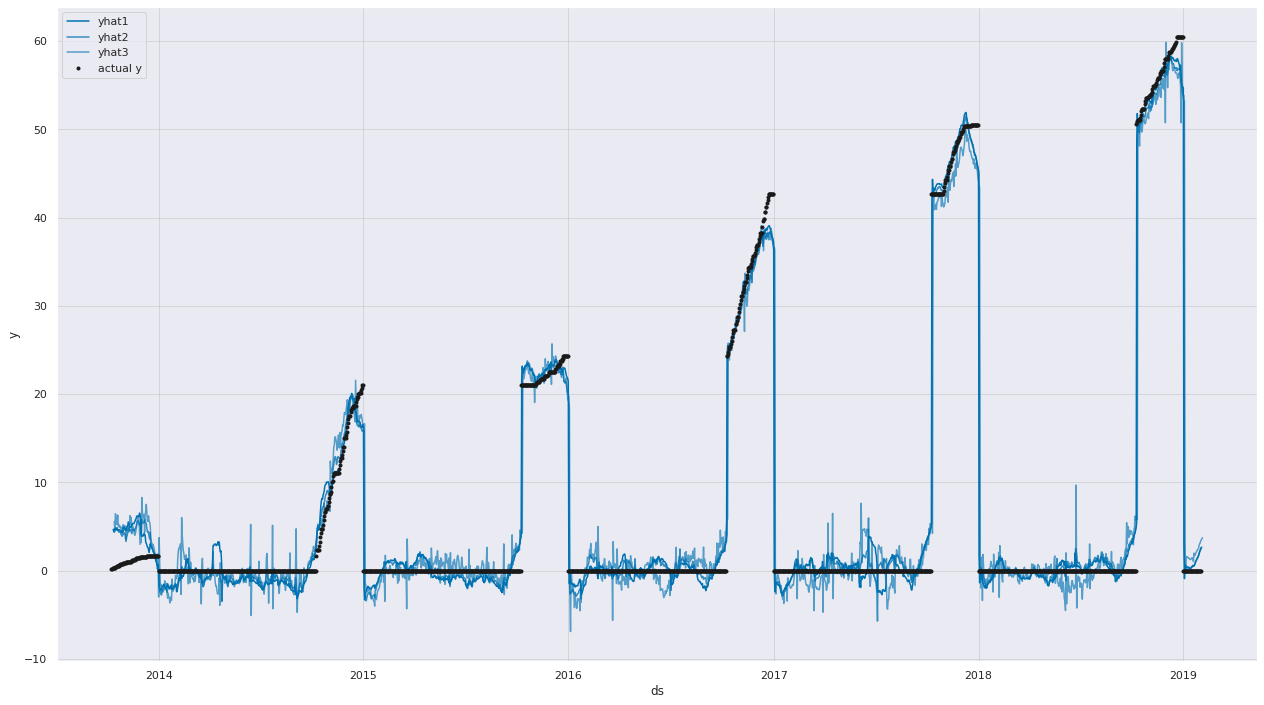

In [ ]:
n_forecast3 = model_3.predict(n_future)
fig1 = model_3.plot(n_forecast3)
fig1.set_size_inches(18.5, 10.5)

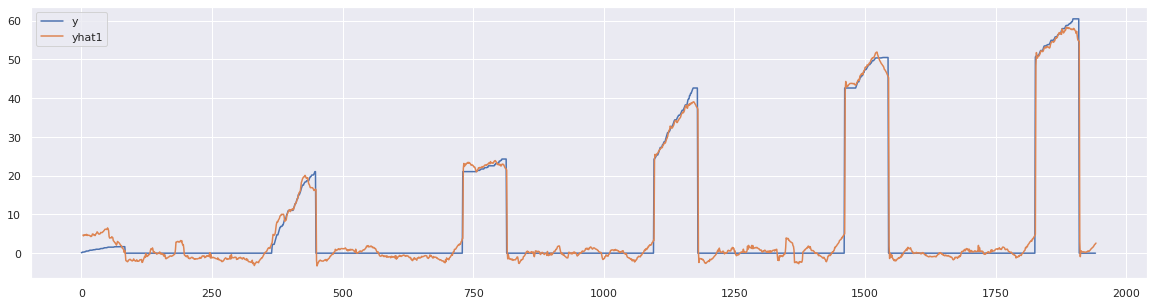

In [ ]:
_ = n_forecast3[['y','yhat1']].plot(figsize=(20, 5))

In [ ]:
p4=n_forecast3

In [ ]:
p4['r_mean']=p4['yhat1'].rolling(3).mean()

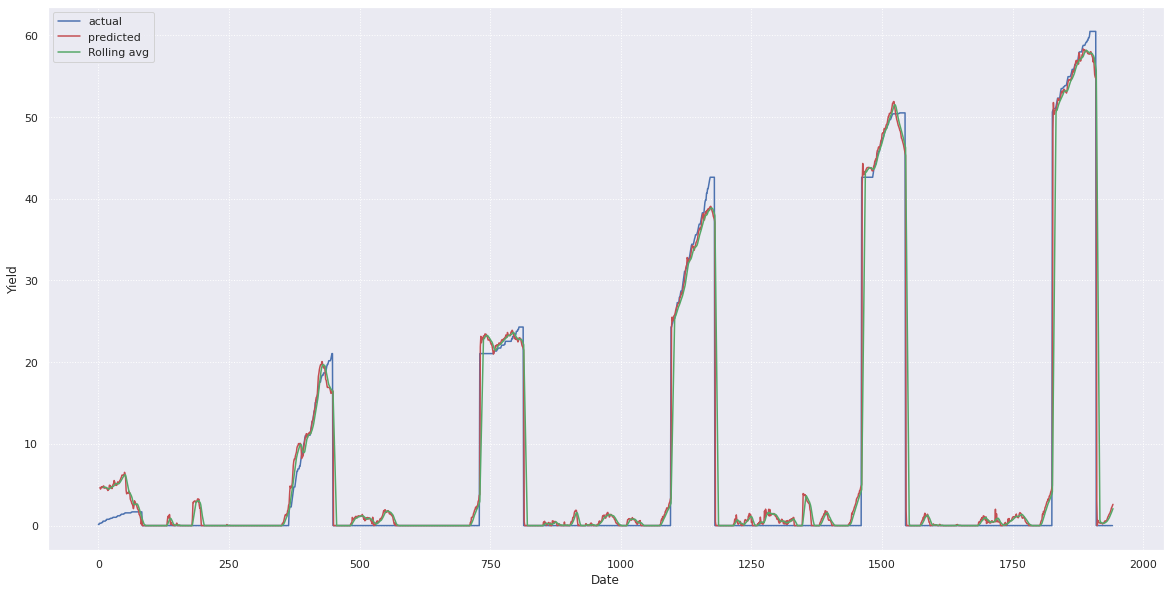

In [ ]:
plt.plot(p4.y,'b-',label='actual')
plt.plot(p4.yhat1.clip(lower=0),'r-',label='predicted')
plt.plot(p4['yhat1'].clip(lower=0).rolling(7).mean(),'g-',label='Rolling avg')
plt.ylabel('Yield')
plt.xlabel('Date')
plt.grid(linestyle=':')
plt.legend(loc='upper left')
plt.show()

In [ ]:
train=dummy3[:-50]
test=dummy3[-50:]

In [ ]:
model_4=NeuralProphet(
    n_forecasts=3,
    n_lags=3,
    learning_rate=0.01,
    n_changepoints=30,
    changepoints_range=0.90,
    trend_reg=1,
)
model_4 = model_4.add_lagged_regressor(names=indep)
metrics4 = model_4.fit(train, freq="D")

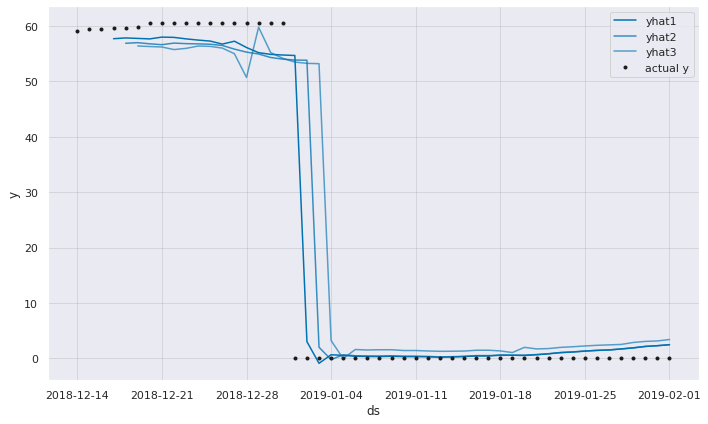

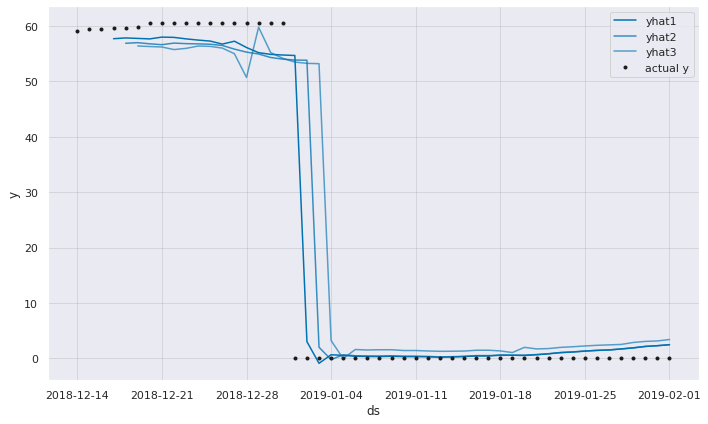

In [ ]:
model_4_forecast = model_3.predict(test)
# fig = m.plot(forecast)
fig1 = model_4.plot(model_4_forecast[-365*24:])
fig2 = model_4.plot(model_4_forecast[-7*24:])

In [ ]:
test_future = model_4.make_future_dataframe(train, periods=365, n_historic_predictions=True)

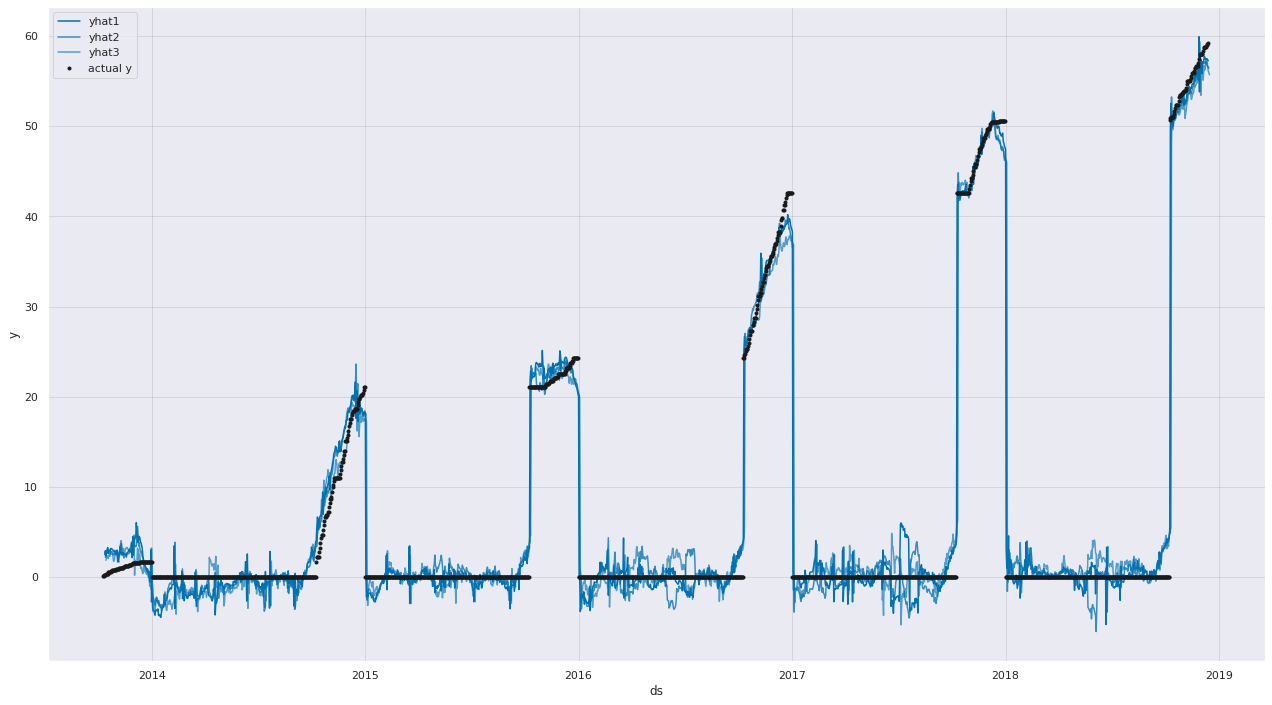

In [ ]:
n_forecast4 = model_4.predict(test_future)
fig1 = model_4.plot(n_forecast4)
fig1.set_size_inches(18.5, 10.5)

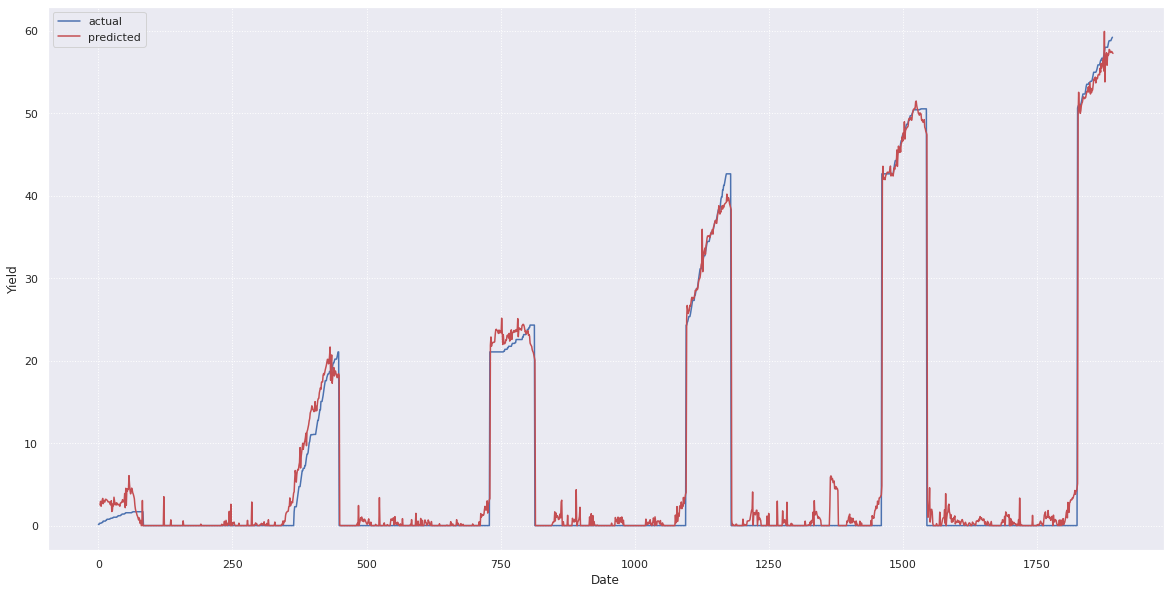

In [ ]:
plt.plot(n_forecast4.y,'b-',label='actual')
plt.plot(n_forecast4.yhat1.clip(lower=0),'r-',label='predicted')
#plt.plot(n_forecast4['yhat1'].clip(lower=0).rolling(7).mean(),'g-',label='Rolling avg')
plt.ylabel('Yield')
plt.xlabel('Date')
plt.grid(linestyle=':')
plt.legend(loc='upper left')
plt.show()

In [ ]:
p2['yhat1'].clip(lower=0).rolling(7).mean()

In [ ]:
p2.yhat1

In [ ]:
m3=NeuralProphet(
    n_forecasts=3,
    n_lags=3,
    learning_rate=0.01,
    n_changepoints=30,
    changepoints_range=0.90,
    trend_reg=1,
)
m3 = m3.add_lagged_regressor(names=indep)
metrics3 = m3.fit(data, freq="D")

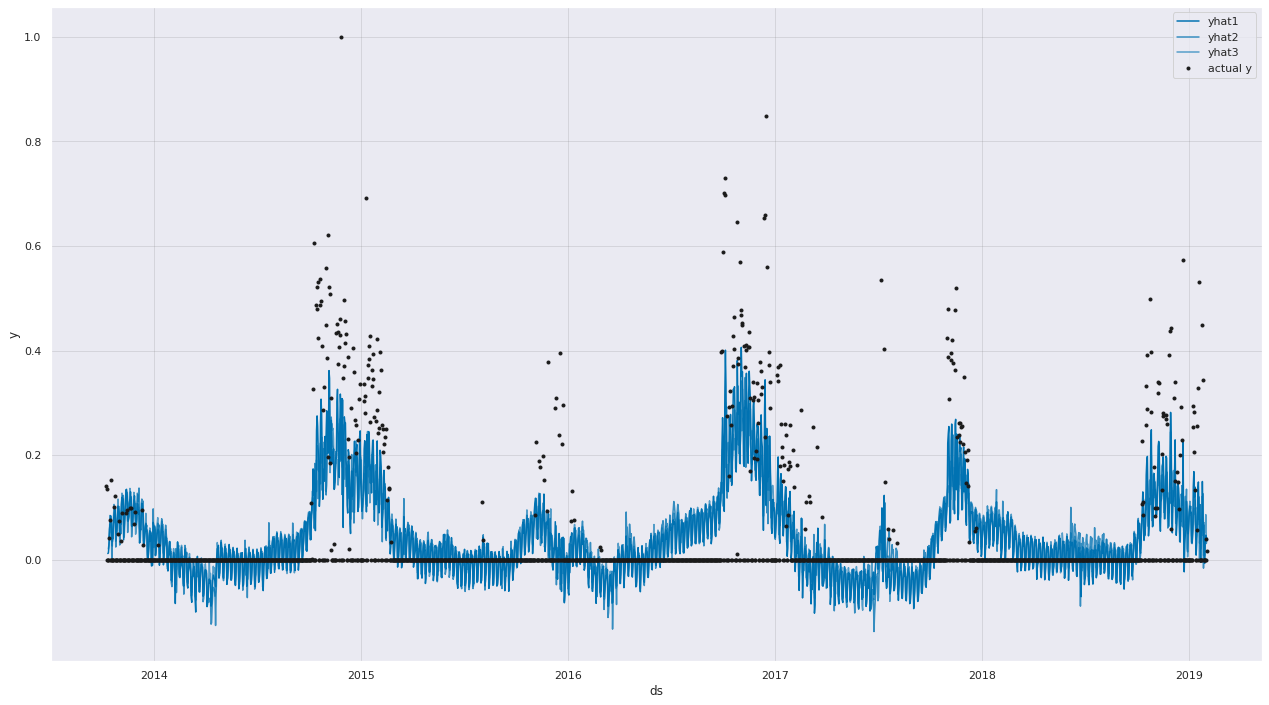

In [ ]:
new_forecast4 = m3.predict(data)
fig1 = m3.plot(new_forecast4)
#fig2 = m3.plot_parameters()
fig1.set_size_inches(18.5, 10.5)

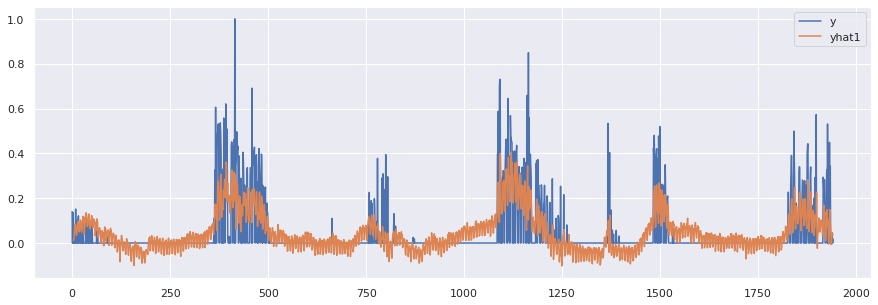

In [ ]:
_ = new_forecast4[['y','yhat1']].plot(figsize=(15, 5))

In [ ]:
train4.head(2)

,ds,y,Tmax,Tmin,NDVI,EVI,NDMI,SAVI,Rain_Amount,Deficit
0,2013-10-09,0.140266,0.29717,0.352113,0.950601,0.800764,0.367895,0.925301,0.000000,0.217155
1,2013-10-10,0.000000,0.34434,0.361502,0.949266,0.794613,0.365547,0.923400,0.006192,0.232131


In [ ]:
#train4=data[:-147]
#test4=data[-147:]
m4=NeuralProphet(
    n_forecasts=3,
    n_lags=3,
    learning_rate=0.01,
    n_changepoints=90,
    changepoints_range=0.90,
    trend_reg=1,
    weekly_seasonality=True,
    daily_seasonality=True,
)
m4 = m4.add_lagged_regressor(names=indep)
metrics5 = m4.fit(data, freq="D")


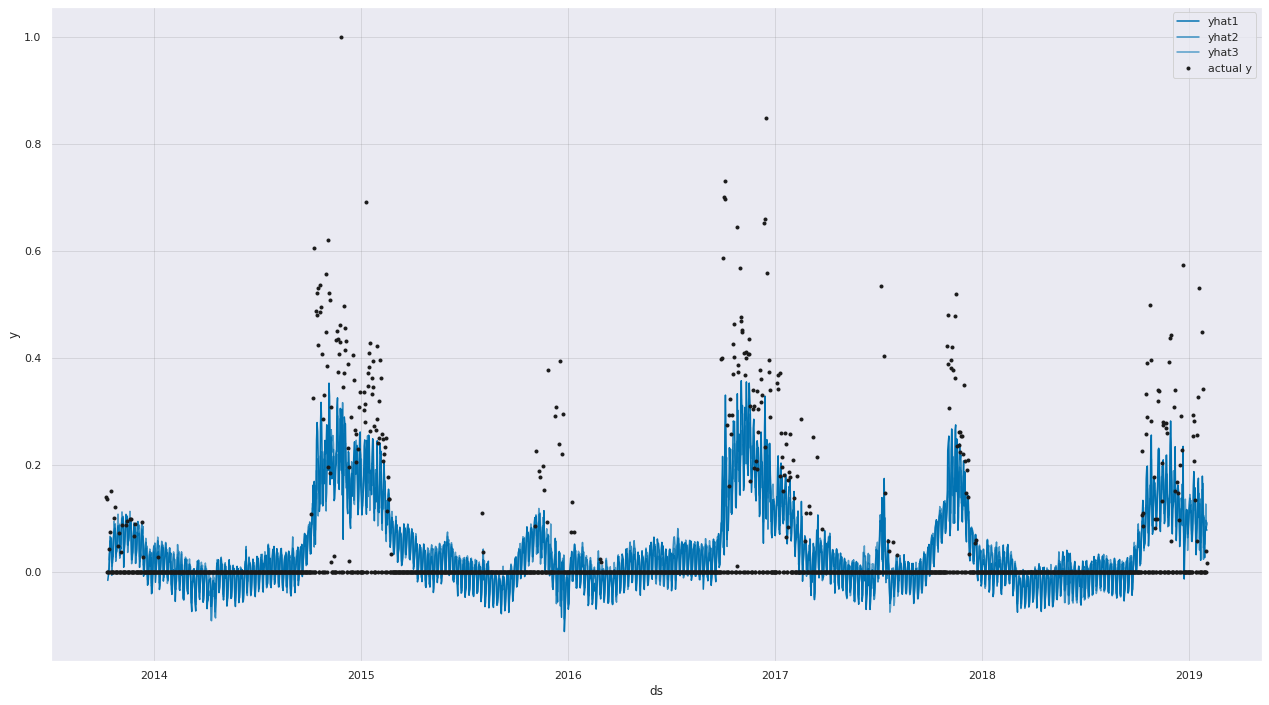

In [ ]:
new_forecast5 = m4.predict(data)
fig1 = m4.plot(new_forecast5)
fig1.set_size_inches(18.5, 10.5)

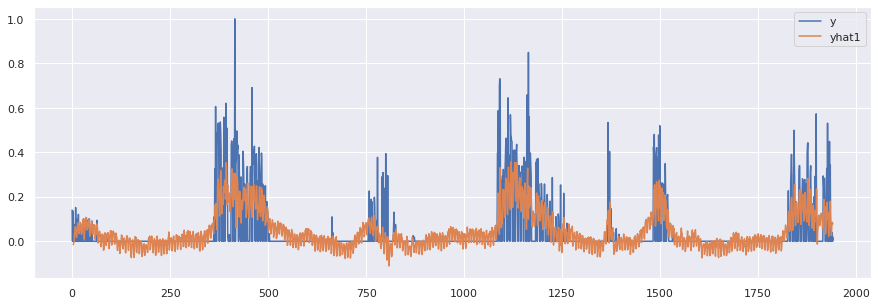

In [ ]:
_ = new_forecast5[['y','yhat1']].plot(figsize=(15, 5))

In [ ]:
#holidays as event
weekend = pd.DataFrame({'event': 'weekends','ds': pd.to_datetime(ss)})
eow=weekend

In [ ]:
#data_eow=pd.merge(data,eow,on='ds',how='left')#merge the data with vegetation indices

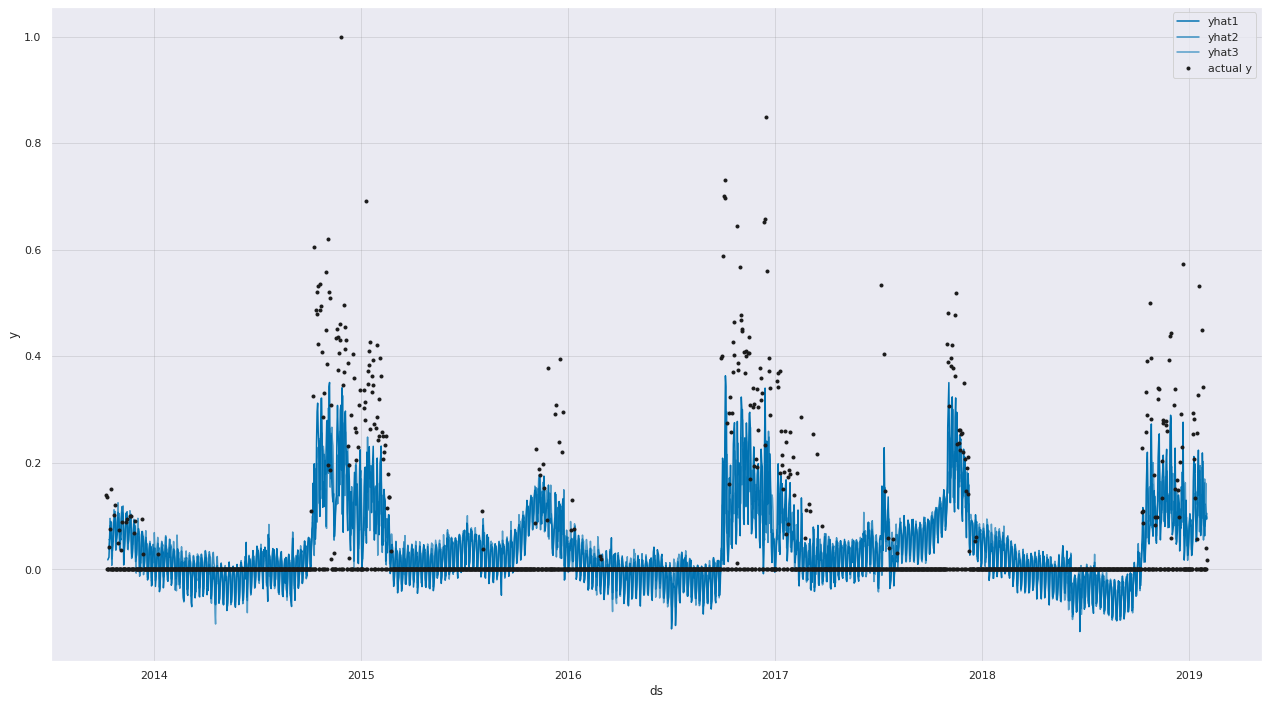

In [ ]:
model5=NeuralProphet(
    n_forecasts=3,
    n_lags=3,
    learning_rate=0.01,
    changepoints=['2013-10-01', '2014-09-01','2015-09-01','2016-09-01','2017-09-01','2018-09-01'],
    n_changepoints=30,
    changepoints_range=0.90,
    trend_reg=1,
    weekly_seasonality=True,
    daily_seasonality=True,
    optimizer='AdamW'
)
model5= model5.add_lagged_regressor(names=indep)
metr = model5.fit(data, freq="D")
n_f = model5.predict(data)
fig1 = model5.plot(n_f)
fig1.set_size_inches(18.5, 10.5)

In [ ]:
data.head(2)

In [ ]:
dummy2=data

In [ ]:
dummy2.set_index('ds',inplace=True)

In [ ]:
dummy2.head(2)

In [ ]:
dummy2=dummy2.reset_index()

In [ ]:
mask1=(dummy2['ds']>'2013-10-09') & (dummy2['ds']<='2014-05-01')
season1=dummy2.loc[mask1]
mask2=(dummy2['ds']>'2014-10-09') & (dummy2['ds']<='2015-05-01')
season2=dummy2.loc[mask2]
mask3=(dummy2['ds']>'2015-10-09') & (dummy2['ds']<='2016-05-01')
season3=dummy2.loc[mask1]
mask4=(dummy2['ds']>'2016-10-09') & (dummy2['ds']<='2017-05-01')
season4=dummy2.loc[mask2]
mask5=(dummy2['ds']>'2017-10-09') & (dummy2['ds']<='2018-05-01')
season5=dummy2.loc[mask1]
mask6=(dummy2['ds']>'2018-10-09') & (dummy2['ds']<='2019-03-01')
season6=dummy2.loc[mask2]

In [ ]:
season1['seasonal_cumsum']=season1['y'].cumsum()

In [ ]:
dummy2['season_cum']=dummy2[dummy2['ds'].apply(lambda x: x.month>=10 and x.month<=4)]['y'].cumsum()

In [ ]:
dummy2.head(40)